# EDA

---
NOTE: Proceed with loading dataset `df_complete.csv` to run the EDA
---

I did not upload the following datasets onto github due to their size:

`allmeters_cleaned_yearly.csv`
`metadata_analysis.csv`
`weather_data.csv`

In [2]:
# load necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


In [14]:
# # Specifying the filepath for the required files
# path_cleaned = "../data/meters/cleaned/"
# path_meta = "../data/metadata/"
# path_weather = "../data/weather_data/"
path = "../data/"

In [15]:
# df_meter = pd.read_csv(path_cleaned + "allmeters_cleaned_yearly.csv")
# df_meta = pd.read_csv(path_meta + "metadata_analysis.csv")
# df_weather = pd.read_csv(path_weather + "weather_data.csv")

In [16]:
# df_meter.head()

In [17]:
# df_meter.info()

In [18]:
# df_meta.head()

In [19]:
# df_meta.info()

In [20]:
# df_weather.head()

In [21]:
# df_weather.info()

In [22]:
# # Merge meter with metadata on building_id, then add weather on site_id and year
# df_complete = (
#     df_meter
#     .merge(df_meta, on="building_id", how="left")
#     .merge(df_weather, on=["site_id", "year"], how="left")
# )

In [23]:
# df_complete.head()


In [ ]:
# # Generate the cleaned file for metadata analysis
# df_complete.to_csv(path + "df_complete.csv", index=False)

In [ ]:
# Load the file
df_complete = pd.read_csv(path + "df_complete.csv")

In [25]:
df_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5902 entries, 0 to 5901
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   building_id                5902 non-null   object 
 1   year                       5902 non-null   int64  
 2   meter                      5902 non-null   object 
 3   total_meter_reading        5902 non-null   float64
 4   site_id                    5902 non-null   object 
 5   sqm                        5902 non-null   float64
 6   primaryspaceusage          5847 non-null   object 
 7   yearbuilt                  2781 non-null   float64
 8   region                     4897 non-null   object 
 9   country                    4897 non-null   object 
 10  Avg_AirTemp_Annual         5902 non-null   float64
 11  Total_HDD_Annual           5902 non-null   float64
 12  Total_CDD_Annual           5902 non-null   float64
 13  Count_Heating_Days_Annual  5902 non-null   int64

In [13]:
  # Ensure correct dtypes 
df_complete['yearbuilt'] = df_complete['yearbuilt'].astype('Int64')

In [14]:
# Define target variable (what is going to be predicted) and features
# The goal is to predict 'total_meter_reading' normalized by 'sqm' (Energy Use Intensity - EUI)
df_complete['eui'] = df_complete['total_meter_reading'] / df_complete['sqm']
target = 'eui'

In [15]:
# Define which columns are numerical and which are categorical
numerical_cols = ['sqm', 'yearbuilt', 'Avg_AirTemp_Annual', 'Total_HDD_Annual',
                      'Total_CDD_Annual', 'Count_Heating_Days_Annual', 'Count_Cooling_Days_Annual', 'total_meter_reading', 'eui']
categorical_cols = ['primaryspaceusage', 'region', 'country', 'meter']

# --- Descriptive Statistics ---

In [16]:
print("\n--- Dataset Description (Numerical) ---")
print(df_complete[numerical_cols].describe())
# print(df_complete[numerical_cols + [target]].describe())


print("\n--- Dataset Description (Categorical) ---")
for col in categorical_cols:
    print(f"\nValue counts for '{col}':")
    print(df_complete[col].value_counts())

# --- Data Quality Checks (Missing Values and Duplicates) ---
print("\n--- Missing Value Report (after cleaning) ---")
print(df_complete.isnull().sum())
print(f"\n--- Duplicate Rows: {df_complete.duplicated().sum()} ---")




--- Dataset Description (Numerical) ---
                sqm    yearbuilt  Avg_AirTemp_Annual  Total_HDD_Annual  \
count   5902.000000       2781.0         5902.000000       5902.000000   
mean    9240.330752  1970.142395           15.672188       1381.255068   
std    10316.382587    29.910355            5.709045       1042.428648   
min       26.300000       1900.0            7.531336         58.533333   
25%     2550.400000       1955.0           10.849792        310.833300   
50%     6100.300000       1975.0           14.965894       1417.439600   
75%    12029.525000       1996.0           21.778797       2285.002200   
max    81290.100000       2017.0           25.208960       3422.980200   

       Total_CDD_Annual  Count_Heating_Days_Annual  Count_Cooling_Days_Annual  \
count       5902.000000                5902.000000                5902.000000   
mean         332.985562                 161.117079                  82.617418   
std          436.849335                  86.82793

In [17]:
# Percentage of missing values in each feature
na_features = [features for features in df_complete.columns if df_complete[features].isnull().sum() > 0]
for features in na_features:
    # Updated to round the missing values percentage to two decimal places
    print(f"{features} : {round(df_complete[features].isnull().mean() * 100, 2)}%")

primaryspaceusage : 0.93%
yearbuilt : 52.88%
region : 17.03%
country : 17.03%


# --- Distribution of Total Meter Reading ---

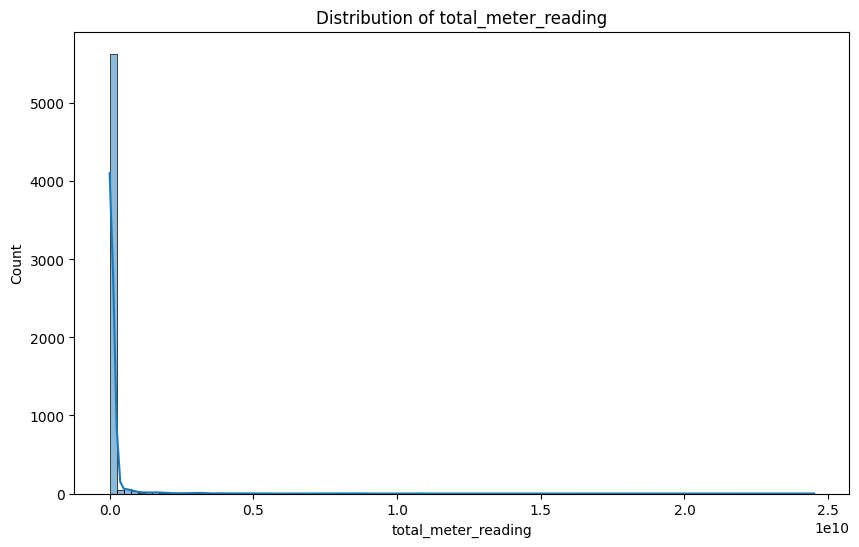

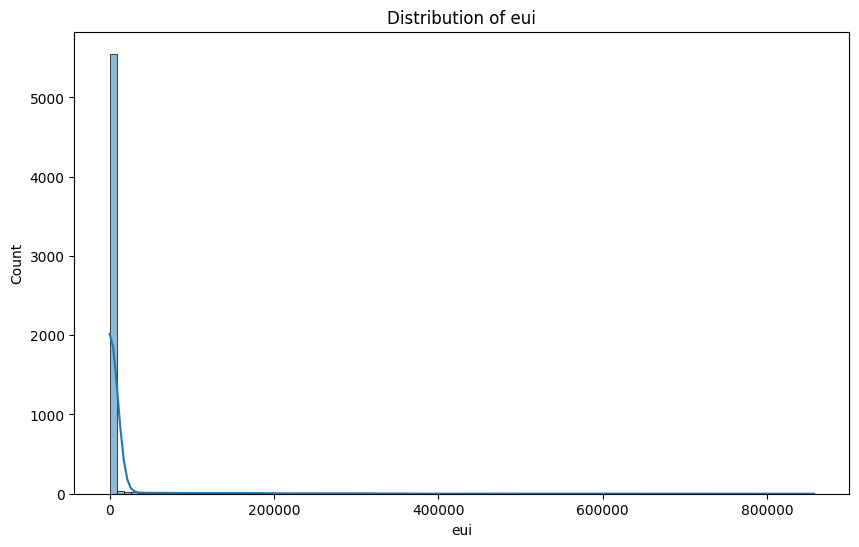

In [18]:
for column in ['total_meter_reading', 'eui']:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_complete[column], bins=100, kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

The histograms show the distribution of `total_meter_reading` and `eui` (Energy Use Intensity), where the majority of values are clustered near zero, indicating heavily right-skewed distributions. High values are rare and likely represent outliers. Since both distributions are severely right-skewed, applying a log transformation may help normalize the data and improve model performance.

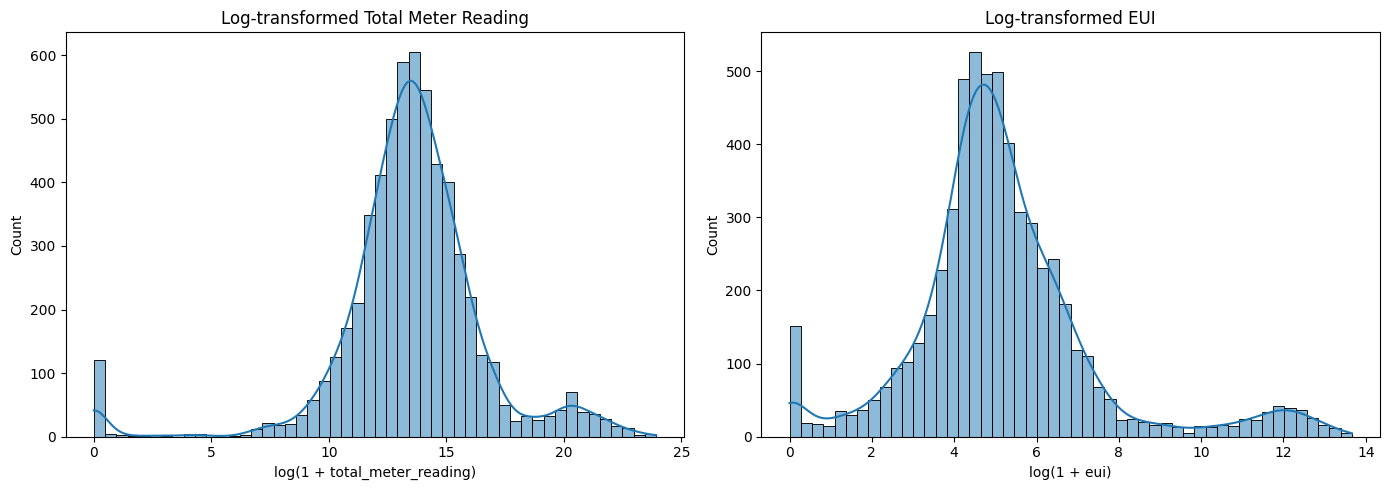

In [19]:
# Apply log transformation to total_meter_reading and eui
df_complete['log_total_meter_reading'] = np.log1p(df_complete['total_meter_reading'])
df_complete['log_eui'] = np.log1p(df_complete['eui'])

# Plot the log-transformed distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df_complete['log_total_meter_reading'], bins=50, kde=True, ax=axes[0])
axes[0].set_title('Log-transformed Total Meter Reading')
axes[0].set_xlabel('log(1 + total_meter_reading)')

sns.histplot(df_complete['log_eui'], bins=50, kde=True, ax=axes[1])
axes[1].set_title('Log-transformed EUI')
axes[1].set_xlabel('log(1 + eui)')

plt.tight_layout()
plt.show()

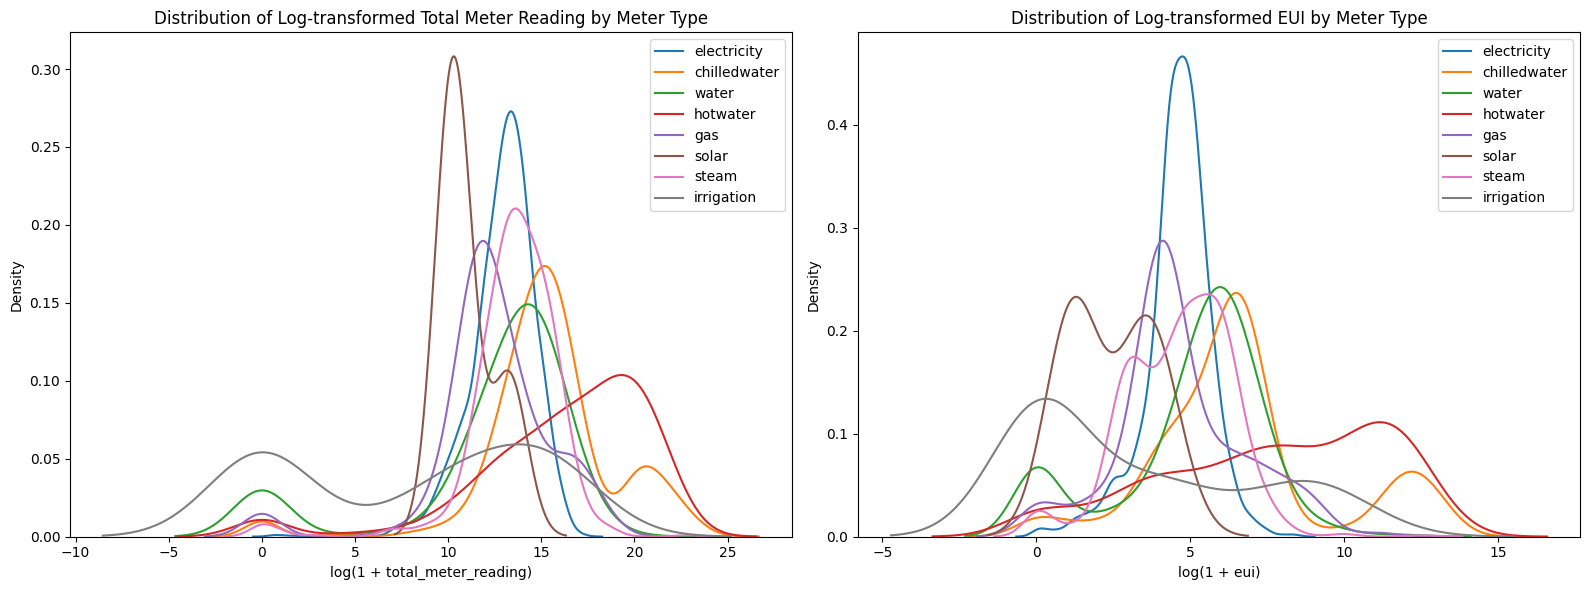

In [20]:
# Distribution of log-transformed total_meter_reading and eui by meter type
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for meter_type in df_complete['meter'].unique():
    subset = df_complete[df_complete['meter'] == meter_type]['log_total_meter_reading']
    sns.kdeplot(subset, ax=axes[0], label=meter_type)
axes[0].set_title('Distribution of Log-transformed Total Meter Reading by Meter Type')
axes[0].set_xlabel('log(1 + total_meter_reading)')
axes[0].legend()

for meter_type in df_complete['meter'].unique():
    subset = df_complete[df_complete['meter'] == meter_type]['log_eui']
    sns.kdeplot(subset, ax=axes[1], label=meter_type)
axes[1].set_title('Distribution of Log-transformed EUI by Meter Type')
axes[1].set_xlabel('log(1 + eui)')
axes[1].legend()

plt.tight_layout()
plt.show()

In [21]:
from scipy.stats import gaussian_kde

# Calculate the highest density (mode of KDE) for each meter type for both metrics

density_peaks_total = {}
density_peaks_eui = {}

for meter_type in df_complete['meter'].unique():
    subset_total = df_complete[df_complete['meter'] == meter_type]['log_total_meter_reading'].dropna()
    subset_eui = df_complete[df_complete['meter'] == meter_type]['log_eui'].dropna()
    
    # Total Meter Reading
    if len(subset_total) > 1:
        kde = gaussian_kde(subset_total)
        x_range = np.linspace(subset_total.min(), subset_total.max(), 1000)
        density = kde(x_range)
        peak_x = x_range[np.argmax(density)]
        peak_density = density.max()
        density_peaks_total[meter_type] = {
            'log_peak': peak_x,
            'original_peak': np.expm1(peak_x),
            'max_density': peak_density
        }
    
    # EUI
    if len(subset_eui) > 1:
        kde = gaussian_kde(subset_eui)
        x_range = np.linspace(subset_eui.min(), subset_eui.max(), 1000)
        density = kde(x_range)
        peak_x = x_range[np.argmax(density)]
        peak_density = density.max()
        density_peaks_eui[meter_type] = {
            'log_peak': peak_x,
            'original_peak': np.expm1(peak_x),
            'max_density': peak_density
        }

# Convert to DataFrames
df_peaks_total = pd.DataFrame(density_peaks_total).T.sort_values('max_density', ascending=False)
df_peaks_eui = pd.DataFrame(density_peaks_eui).T.sort_values('max_density', ascending=False)

print("Highest Density (KDE Peak) for Total Meter Reading by Meter Type:")
print(df_peaks_total)
print("\nHighest Density (KDE Peak) for EUI by Meter Type:")
print(df_peaks_eui)





Highest Density (KDE Peak) for Total Meter Reading by Meter Type:
               log_peak  original_peak  max_density
solar         10.301784   2.978472e+04     0.308196
electricity   13.367188   6.386979e+05     0.272942
steam         13.612370   8.161621e+05     0.210618
gas           11.870304   1.429567e+05     0.189823
chilledwater  15.182054   3.921768e+06     0.173723
water         14.292209   1.610747e+06     0.149075
hotwater      19.305093   2.421561e+08     0.103662
irrigation    13.757949   9.440628e+05     0.059192

Highest Density (KDE Peak) for EUI by Meter Type:
               log_peak  original_peak  max_density
electricity    4.748048     114.358935     0.466669
gas            4.108347      59.846040     0.287707
water          5.964252     388.261900     0.242525
chilledwater   6.482248     652.438087     0.236952
steam          5.557984     258.299482     0.235545
solar          1.294386       2.648753     0.232993
irrigation     0.312821       0.367276     0.133892

The two graphs display the distributions of energy and water consumption metrics across different meter types, using a **logarithmic transformation** to normalize the highly skewed data typically found in real-world energy consumption figures. 


### Left Graph: Distribution of Log-transformed Total Meter Reading by Meter Type 

This graph shows the overall volume of consumption or production for each meter type, regardless of the building size. 

-   **Log Transformation:** The x-axis uses log(1+total_meter_reading), which pulls large values closer to the center and spreads out small values, making the distributions easier to visualize.
-   **Dominant Consumption:** **Electricity** (blue line) and **steam** (purple line) show significant peaks further along the x-axis, indicating that these meter types generally record the highest total consumption volumes across the dataset.
-   **Multi-Modal Distributions:** Several lines (e.g., gas, hotwater, steam) exhibit multiple peaks (multi-modal distributions), which suggests there might be distinct clusters of buildings with very different use profiles (e.g., residential vs. commercial buildings, or different climates where one form of heating dominates).
-   **Low Volume:** **Solar** (dark red line) and **irrigation** (grey line) distributions are clustered farthest to the left on the x-axis, indicating lower overall readings, as would be expected for solar production or specific utility use cases. 
-  **Summary:** The individual curves (like electricity, chilledwater, steam) are visually very narrow and tall. This indicates a tight concentration of total energy volumes within relatively small ranges on the log scale.

### Right Graph: Distribution of Log-transformed EUI by Meter Type 

This graph is more useful for analyzing efficiency. It displays the **Energy Use Intensity (EUI)**, which is the total meter reading normalized by the building's square meter (reading/sqm). This allows for a standardized comparison of efficiency across buildings of different sizes. 

-   **Standardized Comparison:** By accounting for building size, the EUI plot provides a clearer picture of performance.
-   **Highest Density/Common Usage:** The **electricity** distribution (blue line) has the sharpest and highest peak around a log(1+eui) value of 4, indicating that electricity usage is very consistent among a large number of buildings in the dataset when standardized by size.
-   **Efficiency Insights:** The corresponding curves for the EUI (when normalized by sqm) are visibly wider and flatter. This indicates that while EUI standardizes the data, the resulting distribution has a greater variance or spread than the distribution of the raw total readings.
-   **Identifying Outliers/Inefficiencies:** While not explicitly showing individual data points, buildings that fall on the far right tail of their respective EUI curves (e.g., the tail of the electricity curve extending past 10) represent those that consume significantly more energy *per square meter* than their peers, marking them as potential candidates for efficiency improvements. 

### Summary 

The graphs illustrate that while **electricity and steam** account for the highest total consumption volumes (left graph), **electricity and chilledwater** have the most concentrated and commonly observed efficiency profiles (right graph). The log-transformed EUI metric is the superior measure for assessing true energy efficiency and identifying high-performing or underperforming buildings within the scope of an energy management project.

**Why is the EUI spread wider?**
While EUI is a standardized metric that is essential for benchmarking (comparing efficiency across different sized buildings), the normalization process itself reveals a wider range of efficiency performance than raw consumption volume does. In other words, they are spread out over a larger range of the x-axis.

Raw Volume is largely driven by building size (a massive building will always be near the right tail), which keeps that distribution tight.
EUI reveals that among buildings of a similar size, there can be vast differences in operational efficiency, building shell performance, or usage patterns. This inherent variability in efficiency across the building stock results in the wider, flatter distributions seen in the EUI graph.

The two graphs display the distributions of energy and water consumption metrics across different meter types, using a **logarithmic transformation** to normalize the highly skewed data typically found in real-world energy consumption figures. 

### Distribution of Log-transformed Total Meter Reading
The graph on the left illustrates the distribution of log-transformed total meter readings, showing where consumption volumes are most concentrated (density) and where those volumes typically fall (log-peak location), regardless of the building size. 

- **Solar Concentration:** The **solar** meter type exhibits the most concentrated total meter readings, registering the highest maximum density at 0.308. This peak is centered around a moderate log-value of 10.30. While solar's distribution also shows a small density cluster in the negative range, the primary mode is highly concentrated at this positive value.

- **High Volume, Low Concentration:** The **hotwater** distribution (red line) peaks at the highest log-value, 19.31. This peak corresponds to the largest typical total volume (over 242 million in original units). However, its distribution is the least concentrated of the major utilities, with a maximum density of only 0.104. This indicates that hotwater usage can reach massive volumes, but those consumption totals are highly spread out and variable across different consumers.

- **Other Utilities:**  **Electricity** shows the second-highest density (0.273), concentrated around a log-value of 13.37. The distributions for electricity and chilledwater appear visually broader than hotwater and steam, extending further right towards higher total meter readings (up to 25).

### Distribution of Log-transformed EUI (Energy Use Intensity)

The graph on the right displays the **Energy Use Intensity (EUI)**, which is the total meter reading normalized by the building's square footage (reading/sqm). This allows for a standardized comparison of efficiency across buildings of different sizes.  This graph is more useful for analyzing efficiency. It 

- **Dominant Concentration:**  **Electricity** (blue line) displays the greatest concentration by far, reaching the highest peak density of approximately **0.467**. This confirms that nearly half of all electricity EUI readings are tightly clustered around a log-EUI value of 4.75. This peak is visually the tallest and sharpest on the graph.

- **Secondary Concentration:**  **Gas** (purple/indigo) is the second most concentrated utility for EUI, with a density of 0.288, peaking at a log-EUI of 4.11. The **steam** distribution (pink/magenta) also shows a sharp peak, centered slightly to the left of the electricity peak (around a value of 3 visually).

- **Lowest Intensity Mode:** The **solar** meter type, while showing a moderate density of 0.233, registers the lowest typical intensity, peaking at a log-EUI of just 1.29. This confirms that where solar usage is observed, it represents minimal energy use intensity.

- **High EUI Variability Confirmed:** Similar to total consumption, **hotwater** registers the highest typical EUI (log-peak 11.15) but also the lowest concentration of all meter types (0.111 density). This low density coupled with a high log-peak suggests that hotwater intensity varies widely, with no strongly predictable or standard EUI value.

In summary, the analysis highlights that **electricity** exhibits remarkable **standardization and predictability** in its usage, demonstrating high concentration in both total volume and EUI. Conversely, **hotwater** is characterized by high typical volume and high typical intensity, but also **extreme variability**, indicated by low density values in both graphs.

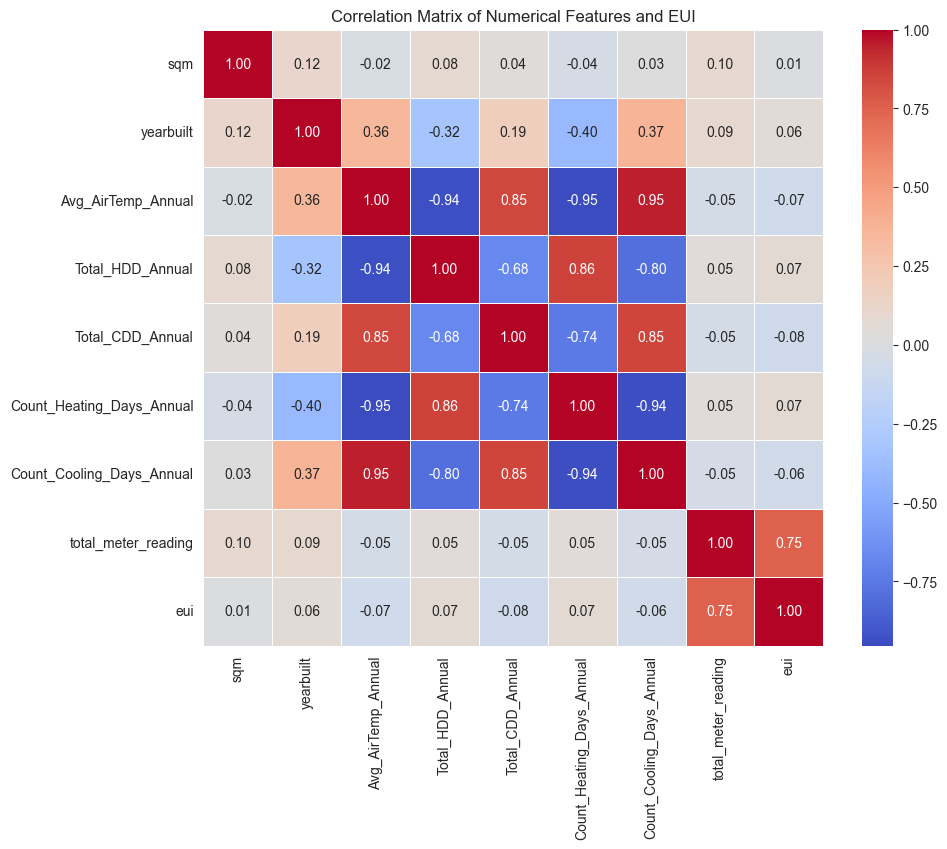

In [ ]:
# Correlation Heatmap for Numerical Features
plt.figure(figsize=(10, 8))
corr_matrix = df_complete[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features and EUI')
plt.show()

The correlation heatmap summarizes the linear relationships among numerical features and Energy Use Intensity (EUI).
Key Findings
1. Strongest Predictor of EUI: The most critical finding is the strong linear relationship between EUI and the raw total consumption metric: total_meter_reading correlates with EUI at 0.75. This indicates that EUI is primarily driven by the overall magnitude of meter consumption.
2. Weak Relationship with EUI: Features traditionally expected to influence building efficiency show negligible linear correlation with EUI:
• Building size (sqm) has a correlation of only 0.01 with EUI.
• All annual weather and climate variables (such as Total_HDD_Annual, Total_CDD_Annual, and Avg_AirTemp_Annual) show correlations with EUI ranging only from -0.05 to -0.07.
3. Internal Feature Correlations: The matrix highlights high redundancy among climate metrics, with near-perfect positive correlations (1.00) between metrics measuring similar conditions (e.g., cooling degree days and count of cooling days). Heating and cooling metrics are strongly negatively correlated, as expected (e.g., -0.94 between Total_HDD_Annual and Count_Cooling_Days_Annual).
In summary, the EUI variation is overwhelmingly explained by the total utility consumption volume, while building size and climate factors appear to have almost no linear association with EUI in this dataset.

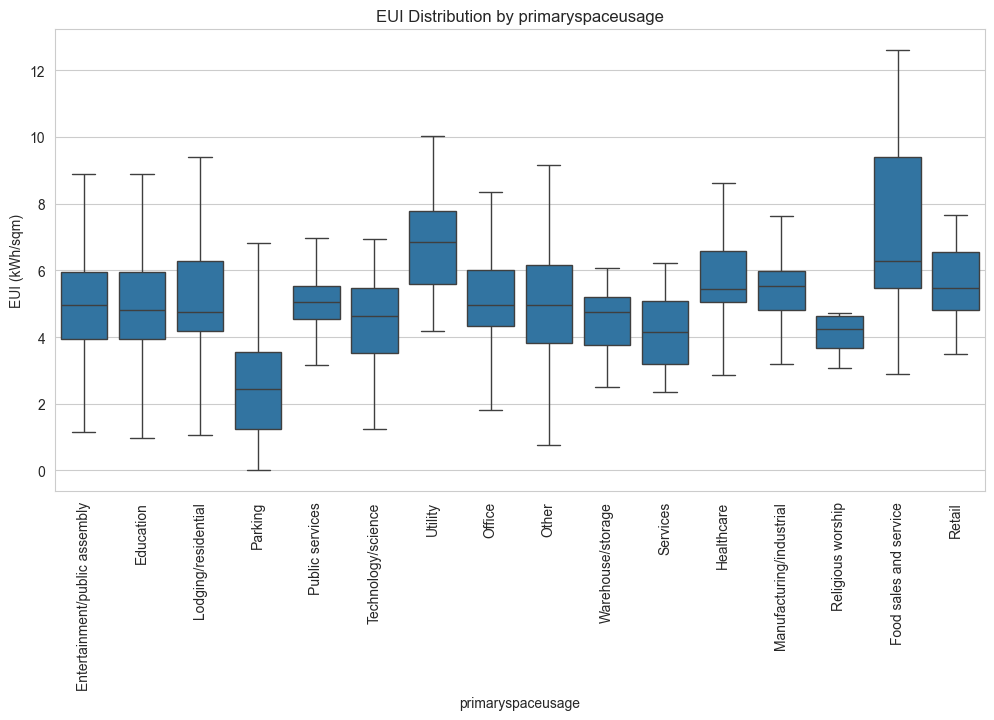

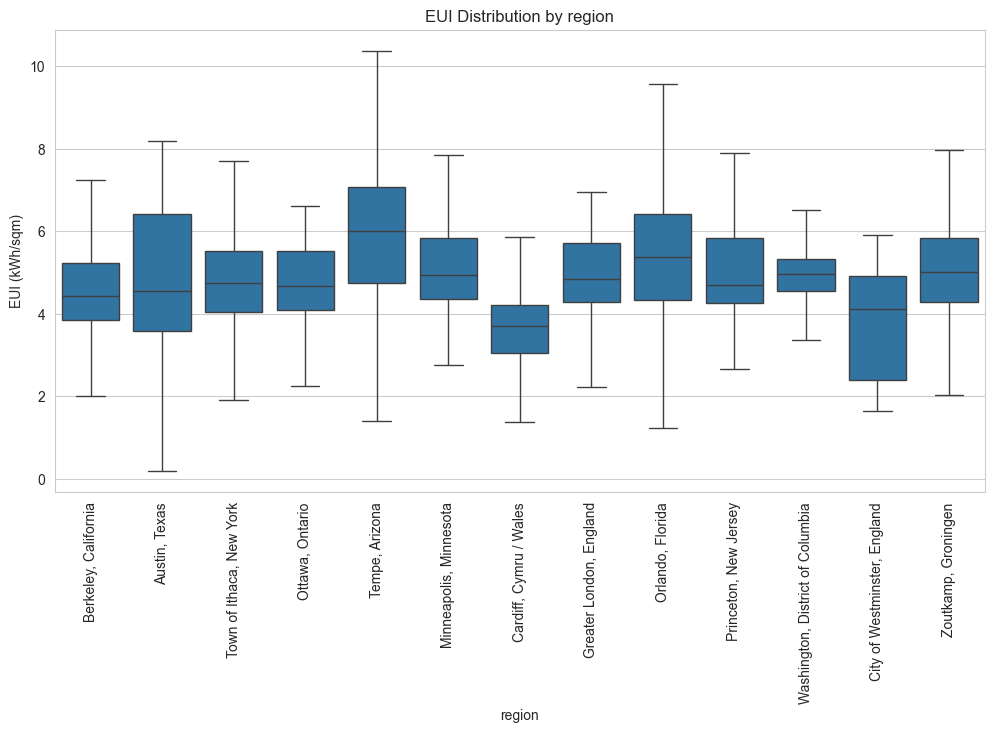

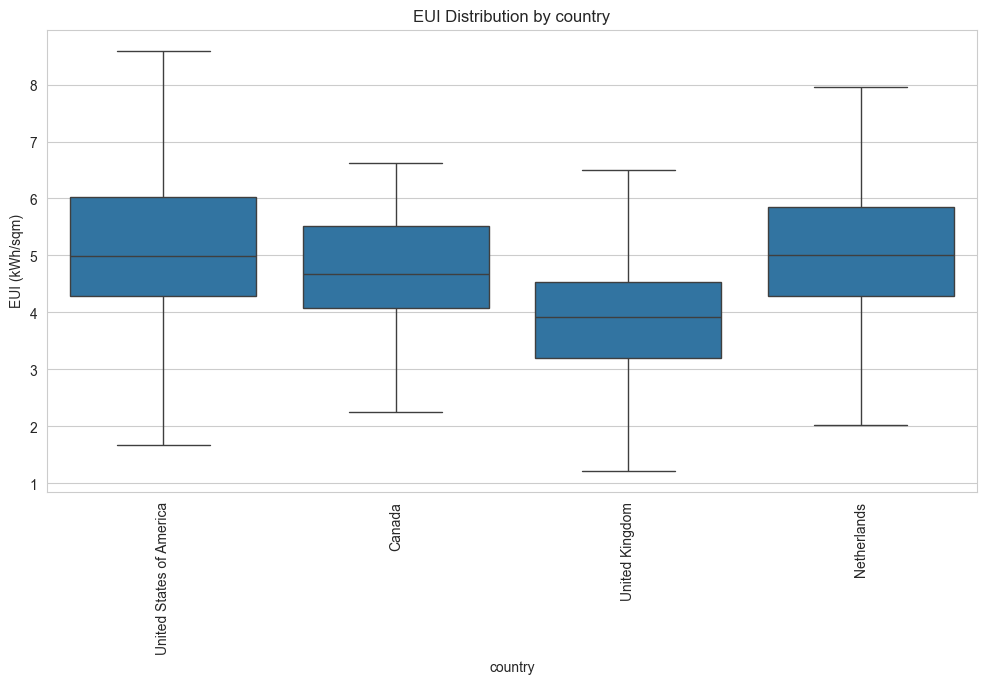

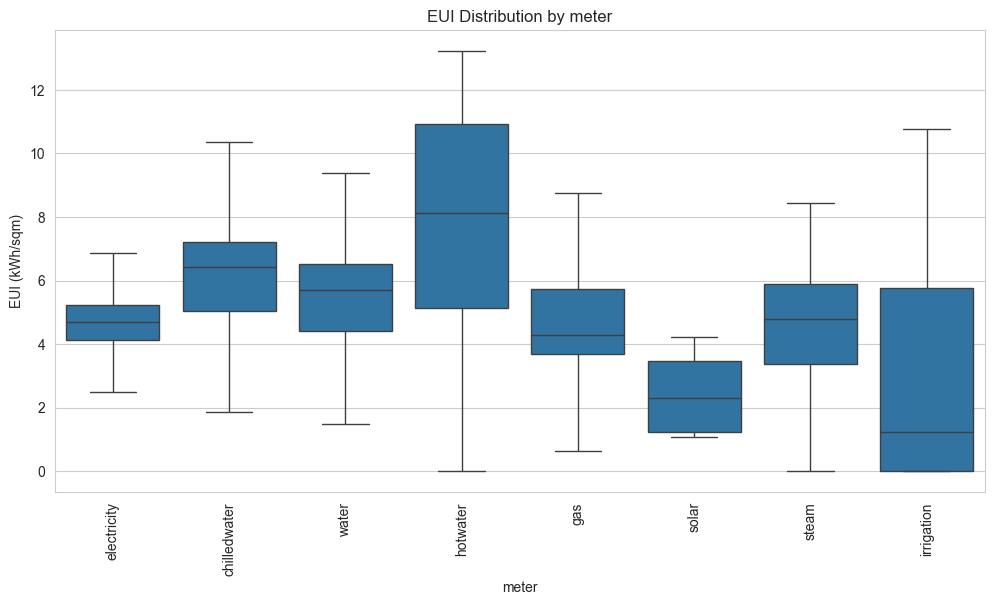

In [ ]:
# Relationship between EUI and Categorical Features (Boxplots)
for col in categorical_cols:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=col, y='log_eui', data=df_complete, showfliers=False) # showfliers=False to manage extreme outliers
    plt.title(f'EUI Distribution by {col}')
    plt.xlabel(col)
    plt.ylabel('EUI (kWh/sqm)')
    plt.xticks(rotation=90)
    plt.show()

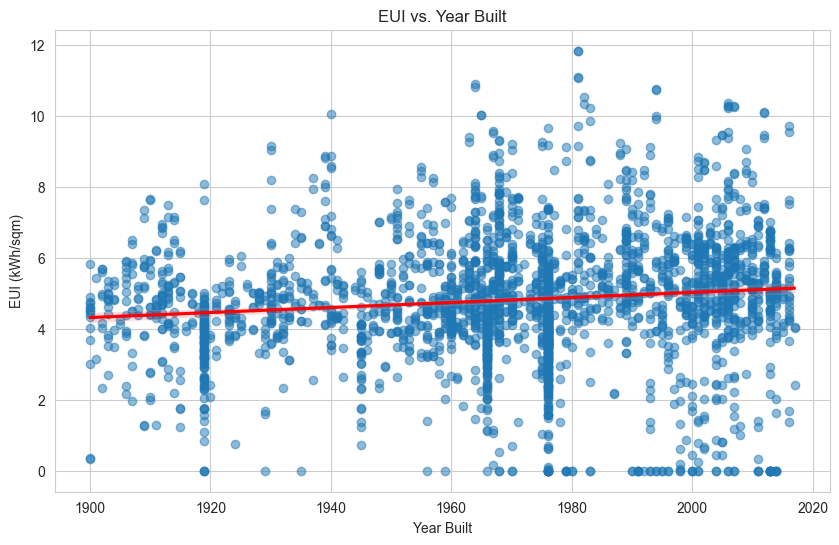

In [25]:
# Impact of Year Built
plt.figure(figsize=(10, 6))
sns.regplot(x='yearbuilt', y='log_eui', data=df_complete, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.title('EUI vs. Year Built')
plt.xlabel('Year Built')
plt.ylabel('EUI (kWh/sqm)')
plt.show()

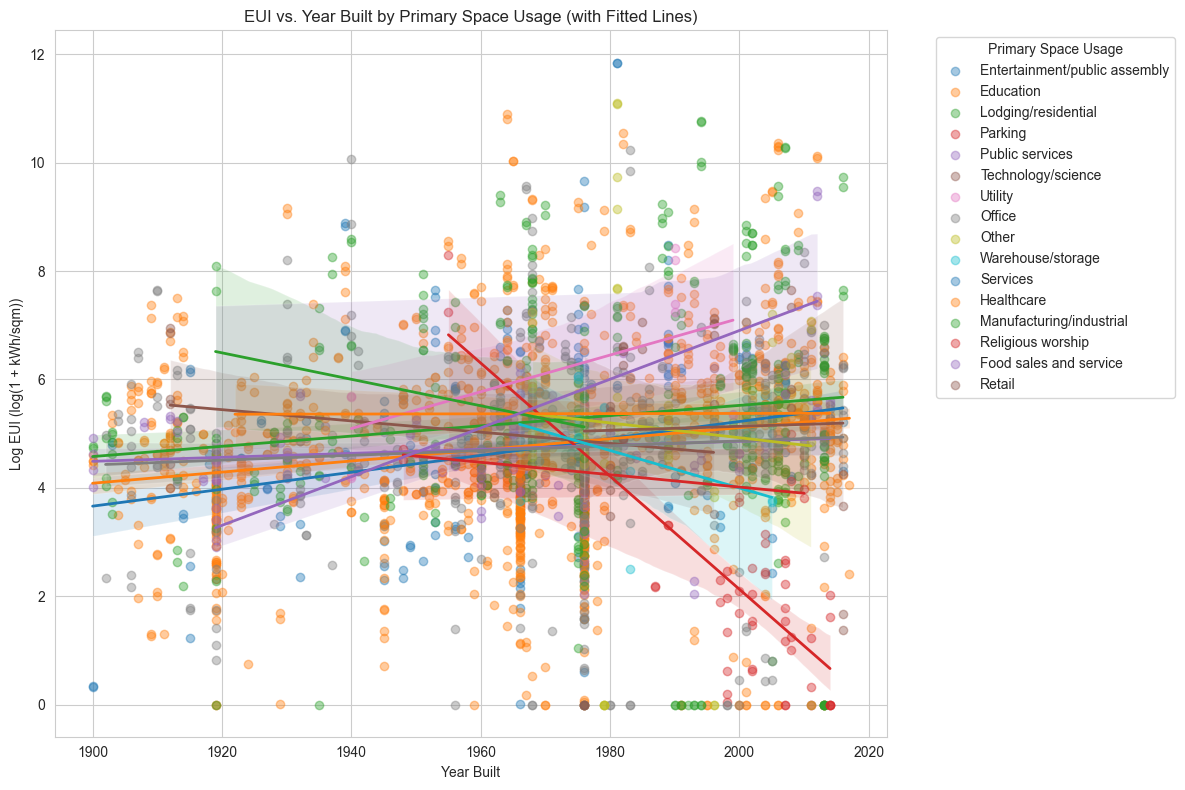

In [26]:
# Scatter plot of EUI vs Year Built, colored by Primary Space Usage with fitted lines
plt.figure(figsize=(12, 8))

# Get unique primary space usages (excluding NaN)
usages = df_complete['primaryspaceusage'].dropna().unique()

for usage in usages:
    subset = df_complete[df_complete['primaryspaceusage'] == usage]
    sns.regplot(
        data=subset,
        x='yearbuilt',
        y='log_eui',
        scatter_kws={'alpha': 0.4},
        label=usage,
        scatter=True,
        line_kws={'linewidth': 2}
    )

plt.title('EUI vs. Year Built by Primary Space Usage (with Fitted Lines)')
plt.xlabel('Year Built')
plt.ylabel('Log EUI (log(1 + kWh/sqm))')
plt.legend(title='Primary Space Usage', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


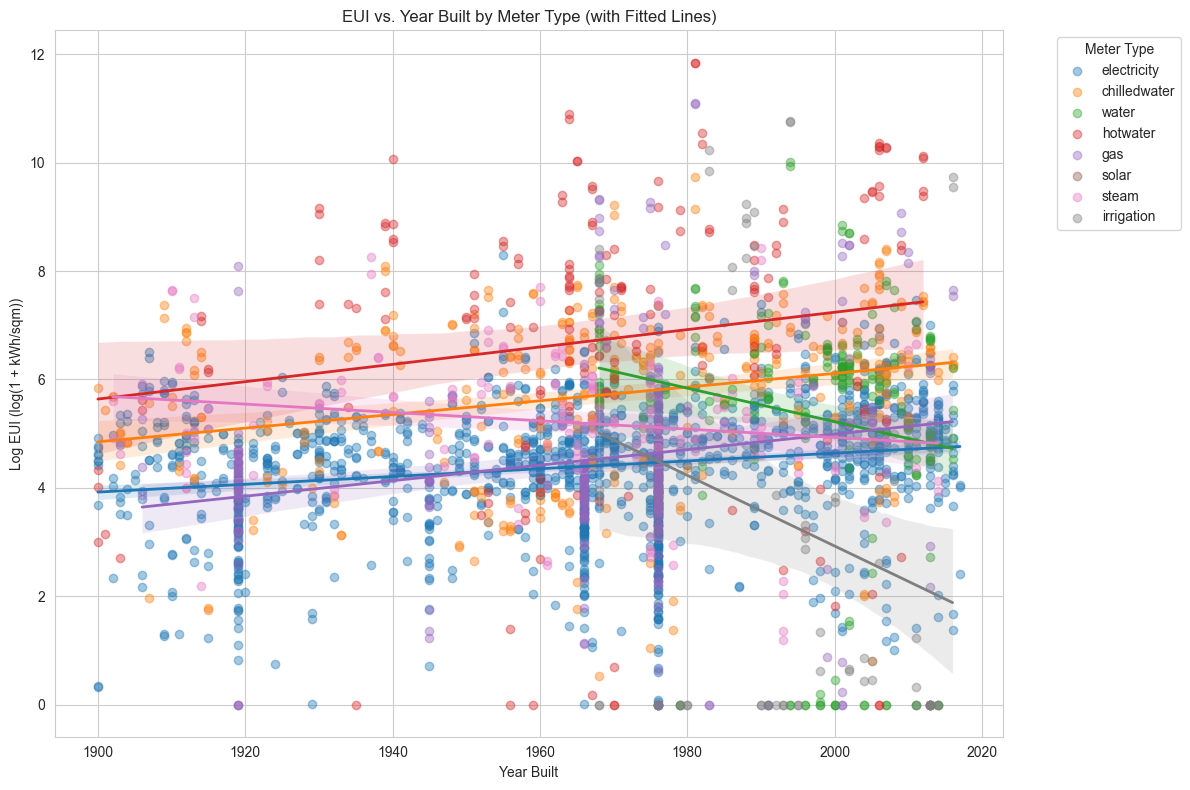

In [27]:
# Scatter plot of EUI vs Year Built, colored by Meter Type with fitted lines
plt.figure(figsize=(12, 8))

# Get unique meter types (excluding NaN)
meters = df_complete['meter'].dropna().unique()

for meter in meters:
    subset = df_complete[df_complete['meter'] == meter]
    sns.regplot(
        data=subset,
        x='yearbuilt',
        y='log_eui',
        scatter_kws={'alpha': 0.4},
        label=meter,
        scatter=True,
        line_kws={'linewidth': 2}
    )

plt.title('EUI vs. Year Built by Meter Type (with Fitted Lines)')
plt.xlabel('Year Built')
plt.ylabel('Log EUI (log(1 + kWh/sqm))')
plt.legend(title='Meter Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

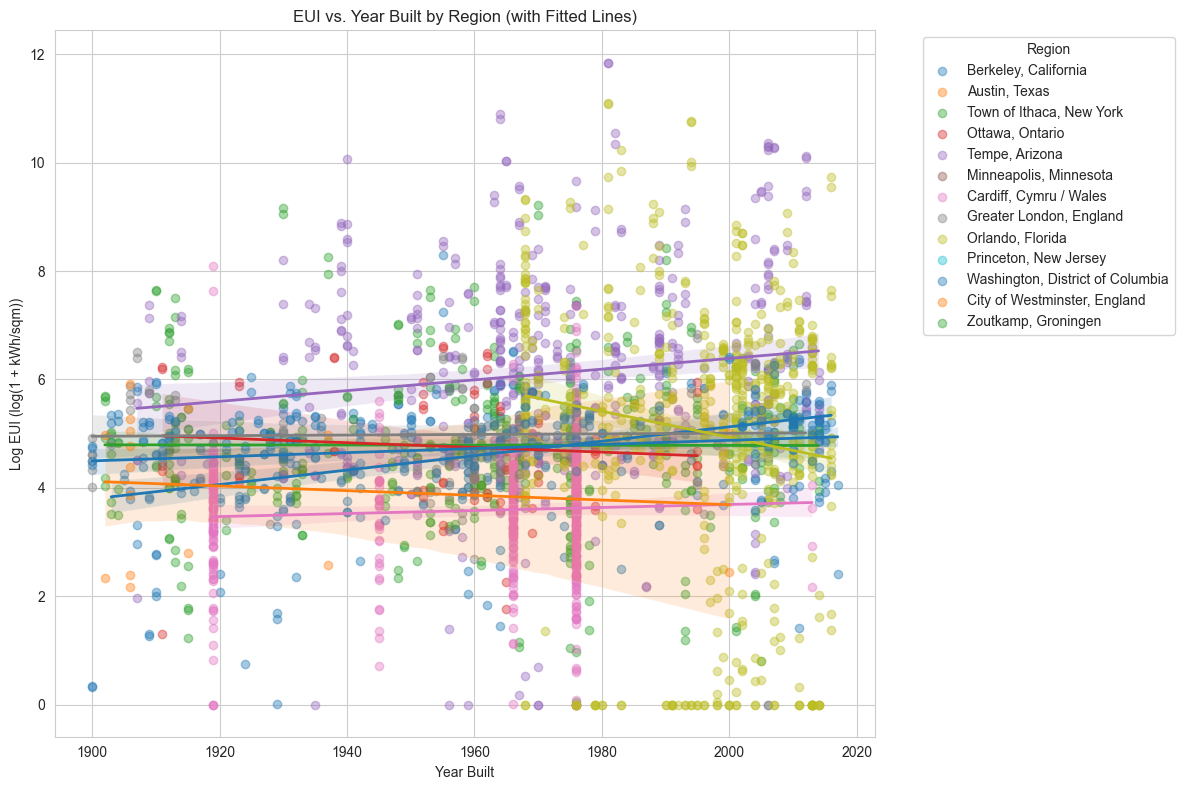

In [28]:
# Scatter plot of EUI vs Year Built, colored by Region with fitted lines
plt.figure(figsize=(12, 8))

# Get unique regions (excluding NaN)
regions = df_complete['region'].dropna().unique()

for region in regions:
    subset = df_complete[df_complete['region'] == region]
    sns.regplot(
        data=subset,
        x='yearbuilt',
        y='log_eui',
        scatter_kws={'alpha': 0.4},
        label=region,
        scatter=True,
        line_kws={'linewidth': 2}
    )

plt.title('EUI vs. Year Built by Region (with Fitted Lines)')
plt.xlabel('Year Built')
plt.ylabel('Log EUI (log(1 + kWh/sqm))')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

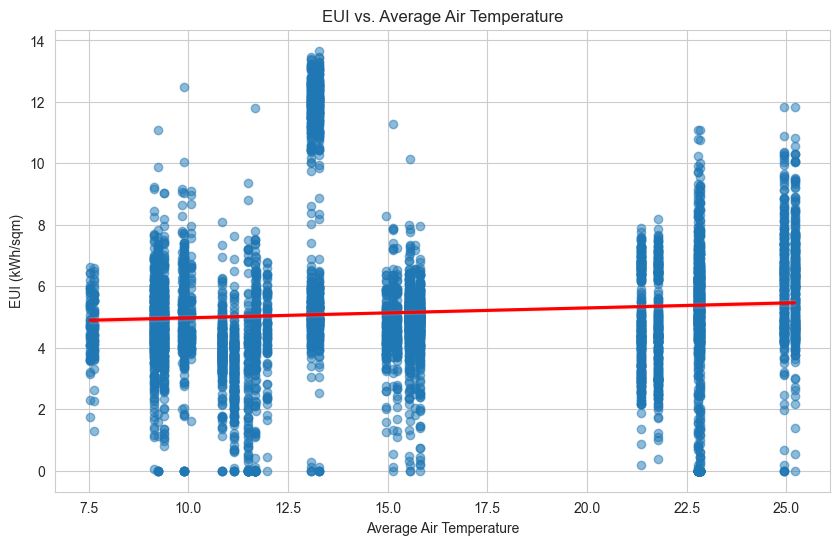

In [29]:
# Impact of Average Air Temperature
plt.figure(figsize=(10, 6))
sns.regplot(x='Avg_AirTemp_Annual', y='log_eui', data=df_complete, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.title('EUI vs. Average Air Temperature')
plt.xlabel('Average Air Temperature')
plt.ylabel('EUI (kWh/sqm)')
plt.show()

In [32]:
df_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5902 entries, 0 to 5901
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   building_id                5902 non-null   object 
 1   year                       5902 non-null   int64  
 2   meter                      5902 non-null   object 
 3   total_meter_reading        5902 non-null   float64
 4   site_id                    5902 non-null   object 
 5   sqm                        5902 non-null   float64
 6   primaryspaceusage          5847 non-null   object 
 7   yearbuilt                  2781 non-null   Int64  
 8   region                     4897 non-null   object 
 9   country                    4897 non-null   object 
 10  Avg_AirTemp_Annual         5902 non-null   float64
 11  Total_HDD_Annual           5902 non-null   float64
 12  Total_CDD_Annual           5902 non-null   float64
 13  Count_Heating_Days_Annual  5902 non-null   int64

In [35]:
keep = ['Avg_AirTemp_Annual', 'year', 'meter', 'site_id', 'region', 'country', 'yearbuilt', 'primaryspaceusage', 'total_meter_reading', 'eui', 'log_eui']

In [36]:
df_analysis = df_complete[keep].copy()

In [39]:
# Generate the cleaned file for metadata analysis
df_analysis.to_csv(path + "df_analysis.csv", index=False)

In [40]:
# Load the cleaned file to verify
df_analysis = pd.read_csv(path + "df_analysis.csv")
df_analysis.head()

,Avg_AirTemp_Annual,year,meter,site_id,region,country,yearbuilt,primaryspaceusage,total_meter_reading,eui,log_eui
0,15.237956,2016,electricity,Bear,"Berkeley, California",United States of America,1933.0,Entertainment/public assembly,3.020396e+06,136.564438,4.924092
1,14.965894,2017,electricity,Bear,"Berkeley, California",United States of America,1933.0,Entertainment/public assembly,4.115350e+06,186.071809,5.231493
2,15.237956,2016,electricity,Bear,"Berkeley, California",United States of America,1958.0,Entertainment/public assembly,3.868207e+05,138.051652,4.934845
3,14.965894,2017,electricity,Bear,"Berkeley, California",United States of America,1958.0,Entertainment/public assembly,3.652301e+05,130.346201,4.877837
4,15.237956,2016,electricity,Bear,"Berkeley, California",United States of America,2016.0,Entertainment/public assembly,5.612824e+05,73.080796,4.305156


In [41]:
df_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5902 entries, 0 to 5901
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Avg_AirTemp_Annual   5902 non-null   float64
 1   year                 5902 non-null   int64  
 2   meter                5902 non-null   object 
 3   site_id              5902 non-null   object 
 4   region               4897 non-null   object 
 5   country              4897 non-null   object 
 6   yearbuilt            2781 non-null   float64
 7   primaryspaceusage    5847 non-null   object 
 8   total_meter_reading  5902 non-null   float64
 9   eui                  5902 non-null   float64
 10  log_eui              5902 non-null   float64
dtypes: float64(5), int64(1), object(5)
memory usage: 507.3+ KB


## Key EDA Findings for Regression Modeling

### 1. Target Variable Transformation Required
- Both `total_meter_reading` and `eui` are **heavily right-skewed** with most values clustered near zero
- **Log transformation (`log1p`)** is essential to normalize the distributions and improve model performance
- The transformed `log_eui` becomes the target variable for modeling

### 2. Weak Linear Relationships with Traditional Predictors
- **Building size (`sqm`)**: Correlation with EUI = **0.01** (essentially no linear relationship)
- **Weather/climate variables** (HDD, CDD, Avg_AirTemp): Correlations with EUI range from **-0.05 to -0.07** (very weak)
- **Total_meter_reading** correlates strongly with EUI (**0.75**) since EUI = total_reading/sqm

**Implication**: Linear regression alone will likely perform poorly; tree-based methods that can capture non-linear relationships are preferable.

### 3. Meter Type Has Distinct Patterns
- **Electricity**: Most concentrated/predictable EUI distribution (highest density ~0.467)
- **Hotwater**: Highest typical EUI but extreme variability (lowest density ~0.111)
- Different meter types have fundamentally different EUI distributions → **meter type is an important categorical feature**

### 4. EUI Shows Greater Variability Than Raw Consumption
- Normalizing by building size reveals **wider performance variance** across buildings
- This variability is what enables identification of underperformers—buildings with similar characteristics but vastly different efficiency

### 5. Climate Variables Are Highly Correlated with Each Other
- Near-perfect correlations between related metrics (e.g., HDD and heating days = 1.00)
- **Feature selection needed** to avoid multicollinearity—use only `Avg_AirTemp_Annual` rather than all climate variables

### 6. Final Feature Set for Modeling
The EDA concludes with selecting these features:
- `Avg_AirTemp_Annual` (climate)
- `meter` (categorical)
- `region` (categorical)
- `yearbuilt` (numerical)
- `primaryspaceusage` (categorical)
- Target: `log_eui`